In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy import constants as const

In [2]:
### FUNCTIONS

def luminosity_bb(T, lambda_1, lambda_2):
    """
    Determines the blackbody flux integrated over some wavelength range

    :param T: the temperature (effective temperature for the star, dayside temperature for the planet) (in Kelvin)
    :type T: float

    :param lambda_1: the lower wavelength bound (in microns)
    :type lambda_1: float

    :param lambda_2: the upper wavelength bound (in microns)
    :type lambda_2: float

    :return: integrated flux
    :rtype: np.array
    """

    bb = BlackBody(temperature=T*u.K)
    wav = np.arange(lambda_1, lambda_2, 0.05) * u.micron
    flux = bb(wav)
    return np.trapezoid(flux)

def phase_planet(t,P,t0=0):
    """
    Determines the phase of a planet at a given time.

    :param t: the time (in days)
    :type t: float

    :param P: the orbital period (in days)
    :type P: float

    :param t0: the reference time (in days)
    :type t0: float

    :return: phase
    :rtype: float
    """

    phase = np.sin(((t+t0)/P)*2*np.pi - np.pi/2)/2+0.5 # equation 15
    return phase

def phase_curve(L_star, L_planet, R_star, R_planet, phase_planet, eclipse, transit_depth, transit):
    """
    Determines the phase curve of a planet from its luminosity, its star's luminosity and its phase function expressed as the ratio between the planet and star's luminosities in ppm.

    :param L_star: the star luminosity (in W)
    :type L_star: float

    :param L_planet: the planet luminosity (in W)
    :type L_planet: float

    :param R_star: the star radius (in m)
    :type R_star: float

    :param R_planet: the planet radius (in m)
    :type R_planet: float

    :param phase_planet: the phase function of the planet
    :type phase_planet: float

    :param eclipse: True if the planet is in eclipse, False otherwise
    :type eclipse: bool

    :return: curve
    :rtype: float
    """
    
    curve = (L_planet/L_star)*phase_planet*(R_planet/R_star)**2 * (-1*eclipse+1) + 1 -transit_depth*transit # *10**6 to have in ppm
    return curve

def transit_depth(R_planet, R_star):
    """
    Determines the depth of an exoplanet transit.

    :param R_planet: the radius of the planet (in m)
    :type Rp: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :return: delta_F
    :rtype: float
    """

    delta_F = (R_planet/R_star)**2
    return delta_F

def transit_impact_parameter(a, i, e, R_star, omega):
    """
    Determines the impact parameter of an exoplanet transit.

    :param a: the semimajor axis (in m)
    :type a: float

    :param i: the inclination (in rad)
    :type i: float

    :param e: the eccentricity
    :type e: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :param omega: the argument of pericentre (in rad)
    :type omega: float

    :return: b
    :rtype: float
    """

    b = a/R_star * np.cos(i) * (1-e**2)/(1+e*np.sin(omega))
    return b

def eclipse_impact_parameter(a, i, e, R_star, omega):
    """
    Determines the impact parameter of an exoplanet eclipse.

    :param a: the semimajor axis (in m)
    :type a: float

    :param i: the inclination (in rad)
    :type i: float

    :param e: the eccentricity
    :type e: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :param omega: the argument of pericentre (in rad)
    :type omega: float

    :return: b
    :rtype: float
    """

    b = a/R_star * np.cos(i) * (1-e**2)/(1-e*np.sin(omega))
    return b

def total_transit_duration(P, a, R_star, R_planet, i, e, omega, b):
    """
    Determines the total duration of an exoplanet transit (in s).

    :param P: the orbital period (in s)
    :type P: float

    :param a: the semimajor axis (in m)
    :type a: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :param R_planet: the radius of the planet (in m)
    :type R_planet: float

    :param i: the inclination (in rad)
    :type i: float

    :param e: the eccentricity
    :type e: float

    :param omega: the argument of pericentre (in rad)
    :type omega: float

    :param b: the transit impact parameter
    :type b: float

    :return: t_total
    :rtype: float
    """

    t_total = P/np.pi * np.arcsin(R_star/a * np.sqrt(((1+R_planet/R_star)**2 - (a/R_star * np.cos(i))**2) / (1-np.cos(i)**2)))

    return t_total

def eclipse(P, a, R_star, R_planet, i, phase, e, omega, b, t):
    """
    Determines if an exoplanet is in eclipse or not at a given phase.

    :param P: the orbital period (in s)
    :type P: float

    :param a: the semimajor axis (in m)
    :type a: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :param R_planet: the radius of the planet (in m)
    :type R_planet: float

    :param i: the inclination (in rad)
    :type i: float

    :param phase: the phase of the exoplanet (in rad)
    :type phase: function

    :param e: the eccentricity
    :type e: float

    :param omega: the argument of pericentre (in rad)
    :type omega: float

    :param b: the impact parameter
    :type b: float

    :return: in_eclipse
    :rtype: bool
    """

    t_eclipse = total_transit_duration(P, a, R_star, R_planet, i, e, omega, b)

    return phase(t, P) > 1 - phase(t_eclipse/2, P)

def transit(P, a, R_star, R_planet, i, phase, e, omega, b, t):
    """
    Determines if an exoplanet is in transit or not at a given phase.

    :param P: the orbital period (in s)
    :type P: float

    :param a: the semimajor axis (in m)
    :type a: float

    :param R_star: the radius of the star (in m)
    :type R_star: float

    :param R_planet: the radius of the planet (in m)
    :type R_planet: float

    :param i: the inclination (in rad)
    :type i: float

    :param phase: the phase of the exoplanet (in rad)
    :type phase: function

    :param e: the eccentricity
    :type e: float

    :param omega: the argument of pericentre (in rad)
    :type omega: float

    :param b: the impact parameter
    :type b: float

    :return: in_eclipse
    :rtype: bool
    """

    t_eclipse = total_transit_duration(P, a, R_star, R_planet, i, e, omega, b)

    return phase(t, P) < phase(t_eclipse/2, P)

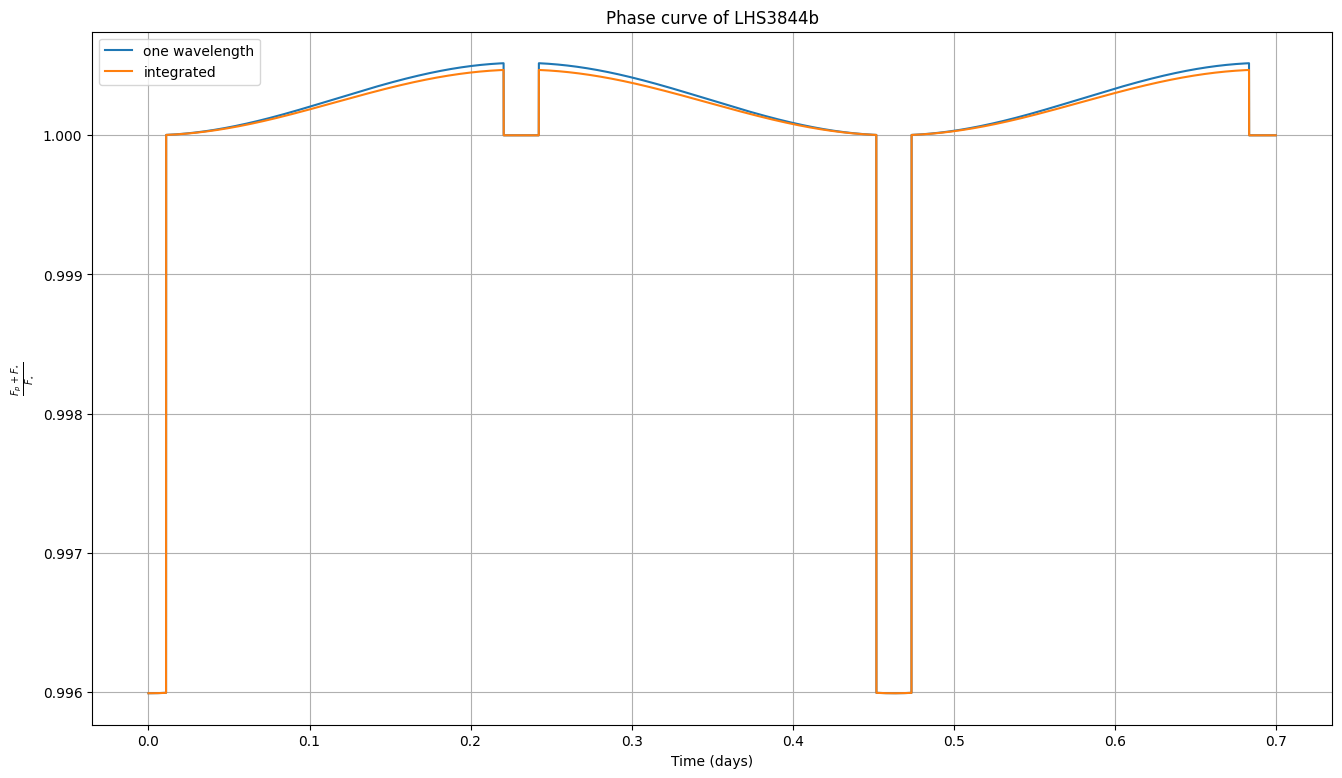

In [7]:
t_start = 0
t_end = 0.7 # simulation duration in days
nb_points = 10000 # number of points in the time array

t = np.linspace(t_start,t_end,nb_points) # time array in days


# For LHS3844 b, data taken from https://exoplanetarchive.ipac.caltech.edu/overview/LHS%203844%20b#planet_LHS-3844-b_collapsible

e = 0.0
P = 0.46292964
omega = 0.0 # bcs e = 0
i = 88.5*np.pi/180
a = 0.00622*149597870700 # a in m
R_star = 0.1886240*const.R_sun.value
R = 1.303*const.R_earth.value
lambda_1 = 5
lambda_2 = 6.1
T_star = 3036
L_star = luminosity_bb(T_star, lambda_1, lambda_2)
T_planet = 1033
L = luminosity_bb(T_planet, lambda_1, lambda_2)
flux_star = BlackBody(T_star*u.K)(5.96*u.micron)
flux_planet = BlackBody(T_planet*u.K)(5.96*u.micron)
phase = phase_planet
b = eclipse_impact_parameter(a,i,e,R_star,omega)
eclipse_bool = eclipse(P,a,R_star,R,i,phase,e,omega,b, t)
b = transit_impact_parameter(a,i,e,R_star,omega)
phase_curvee = phase_curve(flux_star,flux_planet,R_star,R,phase(t, P),eclipse_bool, transit_depth(R, R_star), transit(P, a, R_star, R, i, phase, e, omega, b, t))
phase_curvee2 = phase_curve(L_star,L,R_star,R,phase(t, P),eclipse_bool, transit_depth(R, R_star), transit(P, a, R_star, R, i, phase, e, omega, b, t))

plt.figure(figsize=(16,9))
plt.plot(t, phase_curvee, label='one wavelength')
plt.plot(t, phase_curvee2, label='integrated')
plt.xlabel("Time (days)")
plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
plt.title("Phase curve of LHS3844b")
plt.legend()
plt.grid()
plt.show()